In [136]:
import torch.nn as nn
import numpy as np
np.bool8 = np.bool_
import copy

In [137]:
import torch.nn.functional as F

In [138]:
class MLP(nn.Module):
    
    def __init__(self,n_states,n_actions,hidden_dim=128):
        
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(n_states,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,n_actions)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [139]:
from collections import deque
import random
class ReplayBuffer(object):
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        ''' 存储transition到经验回放中
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer): # 如果批量大小大于经验回放的容量，则取经验回放的容量
            batch_size = len(self.buffer)
        if sequential: # 顺序采样
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else: # 随机采样
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        ''' 清空经验回放
        '''
        self.buffer.clear()
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)

In [140]:
import torch
import torch.optim as optim
import math
import numpy as np

In [141]:
class DQN:
    
    def __init__(self,model,memory,cfg):
        
        self.n_actions = cfg['n_actions']
        self.device = torch.device(cfg['device'])
        self.gamma = cfg['gamma']
        self.sample_count = 0
        self.epsilon = cfg['epsilon_start']
        self.epsilon_start = cfg['epsilon_start']
        self.epsilon_end = cfg['epsilon_end']
        self.epsilon_decay = cfg['epsilon_decay']
        self.batch_size = cfg['batch_size']
        
        self.policy_net = model.to(self.device)
        self.target_net = copy.deepcopy(model).to(self.device)
        
        for target_param, param in zip(self.target_net.parameters(),
                                      self.policy_net.parameters()):
            target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(),
                                   lr=cfg['lr'])
        self.memory = memory
    
    def sample_action(self, state):
        ''' 采样动作
        '''
        self.sample_count += 1
        # epsilon指数衰减
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) 
        if random.random() > self.epsilon:
            with torch.no_grad():
                state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item() # choose action corresponding to the maximum q value
        else:
            action = random.randrange(self.n_actions)
        return action
    
    @torch.no_grad()
    def predict_action(self,state):
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        q_values = self.policy_net(state)
        action = q_values.max(1)[1].item()
        return action
    

    def update(self):
        if len(self.memory) < self.batch_size: # 当经验回放中不满足一个批量时，不更新策略
            return
        # 从经验回放中随机采样一个批量的转移(transition)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(
            self.batch_size)
        # 将数据转换为tensor
        state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)  
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float)  
        next_state_batch = torch.tensor(np.array(next_state_batch), device=self.device, dtype=torch.float)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device)
        
        q_values = self.policy_net(state_batch).gather(dim=1,index=action_batch)
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach() # 计算下一时刻的状态(s_t_,a)对应的Q值
        
        expected_q_values = reward_batch + self.gamma * next_q_values * (1-done_batch)
        
        loss = nn.MSELoss()(q_values,expected_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1,1)
        self.optimizer.step()

In [142]:
def train(cfg, env, agent):
    ''' 训练
    '''
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg['train_eps']):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state,_ = env.reset()  # 重置环境，返回初始状态
        for _ in range(cfg['ep_max_steps']):
            ep_step += 1
            action = agent.sample_action(state)  # 选择动作
#             next_state, reward, terminated, truncated, _
            next_state, reward, done, _,_ = env.step(action)  # 更新环境，返回transition
            agent.memory.push((state, action, reward,next_state, done))  # 保存transition
            state = next_state  # 更新下一个状态
            agent.update()  # 更新智能体
            ep_reward += reward  # 累加奖励
            if done:
                break
        if (i_ep + 1) % cfg['target_update'] == 0:  # 智能体目标网络更新
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        steps.append(ep_step)
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg['train_eps']}，奖励：{ep_reward:.2f}，Epislon：{agent.epsilon:.3f}")
    print("完成训练！")
    env.close()
    return {'rewards':rewards}


In [143]:
def test(cfg, env, agent):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg['test_eps']):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state,_ = env.reset()  # 重置环境，返回初始状态
        for _ in range(cfg['ep_max_steps']):
            ep_step+=1
            action = agent.predict_action(state)  # 选择动作
            next_state, reward, done, _,_ = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if done:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg['test_eps']}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards':rewards}

In [144]:
import gym
import os
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg['env_name']) # 创建环境
    if cfg['seed'] !=0:
        all_seed(env,seed=cfg['seed'])
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")
    cfg.update({"n_states":n_states,"n_actions":n_actions}) # 更新n_states和n_actions到cfg参数中
    model = MLP(n_states, n_actions, hidden_dim = cfg['hidden_dim']) # 创建模型
    memory = ReplayBuffer(cfg['memory_capacity'])
    agent = DQN(model,memory,cfg)
    return env,agent

In [145]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
def get_args():
    """ 超参数
    """
    parser = argparse.ArgumentParser(description="hyperparameters")      
    parser.add_argument('--algo_name',default='DQN',type=str,help="name of algorithm")
    parser.add_argument('--env_name',default='CartPole-v0',type=str,help="name of environment")
    parser.add_argument('--train_eps',default=200,type=int,help="episodes of training")
    parser.add_argument('--test_eps',default=20,type=int,help="episodes of testing")
    parser.add_argument('--ep_max_steps',default = 100000,type=int,help="steps per episode, much larger value can simulate infinite steps")
    parser.add_argument('--gamma',default=0.95,type=float,help="discounted factor")
    parser.add_argument('--epsilon_start',default=0.95,type=float,help="initial value of epsilon")
    parser.add_argument('--epsilon_end',default=0.01,type=float,help="final value of epsilon")
    parser.add_argument('--epsilon_decay',default=500,type=int,help="decay rate of epsilon, the higher value, the slower decay")
    parser.add_argument('--lr',default=0.0001,type=float,help="learning rate")
    parser.add_argument('--memory_capacity',default=100000,type=int,help="memory capacity")
    parser.add_argument('--batch_size',default=64,type=int)
    parser.add_argument('--target_update',default=4,type=int)
    parser.add_argument('--hidden_dim',default=256,type=int)
    parser.add_argument('--device',default='cpu',type=str,help="cpu or cuda") 
    parser.add_argument('--seed',default=10,type=int,help="seed")   
    args = parser.parse_args([])
    args = {**vars(args)}  # 转换成字典类型    
    ## 打印超参数
    print("超参数")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k,v in args.items():
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))      
    return args
def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

In [146]:
def plot_rewards(rewards,cfg, tag='train'):
    ''' 画图
    '''
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg['device']} of {cfg['algo_name']} for {cfg['env_name']}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()

超参数
        Name        	       Value        	        Type        
     algo_name      	        DQN         	   <class 'str'>    
      env_name      	    CartPole-v0     	   <class 'str'>    
     train_eps      	        200         	   <class 'int'>    
      test_eps      	         20         	   <class 'int'>    
    ep_max_steps    	       100000       	   <class 'int'>    
       gamma        	        0.95        	  <class 'float'>   
   epsilon_start    	        0.95        	  <class 'float'>   
    epsilon_end     	        0.01        	  <class 'float'>   
   epsilon_decay    	        500         	   <class 'int'>    
         lr         	       0.0001       	  <class 'float'>   
  memory_capacity   	       100000       	   <class 'int'>    
     batch_size     	         64         	   <class 'int'>    
   target_update    	         4          	   <class 'int'>    
     hidden_dim     	        256         	   <class 'int'>    
       device       	        cpu         	   <class

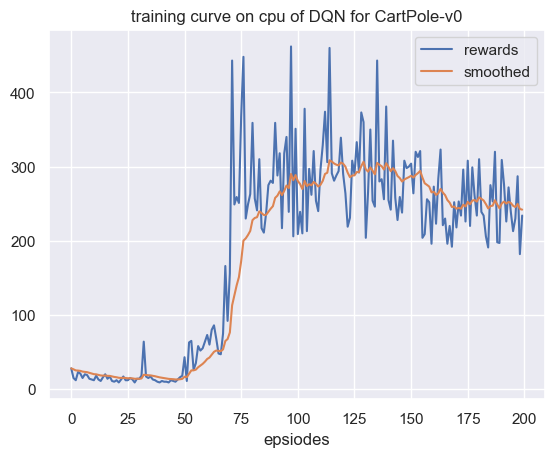

开始测试！
回合：1/20，奖励：288.00
回合：2/20，奖励：198.00
回合：3/20，奖励：205.00
回合：4/20，奖励：317.00
回合：5/20，奖励：287.00
回合：6/20，奖励：191.00
回合：7/20，奖励：177.00
回合：8/20，奖励：246.00
回合：9/20，奖励：268.00
回合：10/20，奖励：186.00
回合：11/20，奖励：296.00
回合：12/20，奖励：258.00
回合：13/20，奖励：191.00
回合：14/20，奖励：208.00
回合：15/20，奖励：272.00
回合：16/20，奖励：238.00
回合：17/20，奖励：348.00
回合：18/20，奖励：199.00
回合：19/20，奖励：303.00
回合：20/20，奖励：236.00
完成测试


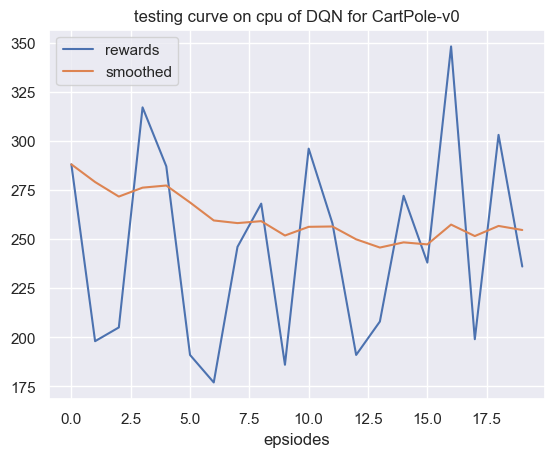

In [147]:
# 获取参数
cfg = get_args() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果